### Prepare Data for Naïve Bayes in Python

#### In this part, we will divide it into two parts. According to our question list, we use naive Bayes to explore the question about what tweets about work will be favorited by people and what tweets about work will be retweeted by people. So we should use the tweets with the keyword of job or work in this part, which should be textcleaning_py3.csv that you can find in the data tab and it is in the 01-modified-data.


In [11]:
import pandas as pd
df = pd.read_csv("data/01-modified-data/textcleaning_py3.csv")
df = df[["id","favorited","retweeted","Clean_Text"]]
df = df.dropna()

#### Let's take a look of our labeled text data as it shows below.

In [12]:
df.head()

,id,favorited,retweeted,Clean_Text
0,1600166363456507904,False,True,rt scjchurch_en new york feature zion christia...
1,1600166363347419136,False,False,rt arynewsofficial mbbs graduate set new world...
2,1600166362420170762,False,True,rt tedchris number number feel like world chan...
3,1600166362139480066,False,False,rt namyrmya wait go to announce new actor s be...
4,1600166361803653131,False,True,rt concepttvnew mbbs graduate hafiz muhammad w...


#### Data preparation includes extracting dependent variable, retweeted, whether the tweet is retweeted or not and texts as input.  And it also includes the process of spliting training and testing sets. We split the labeled text data into train and test with 70% trainning ratio.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df["Clean_Text"], df["retweeted"], test_size=0.3, random_state=0)

#### In this method, the assumption of Naive Bayes assumption is that each feature makes an independent and equal contribution to the outcome. And when it comes to texts, we have a concept, which is bag of words as we treat each token independent, conditioned on class label. So we must count vectorizer our texts to get the matrix for maximizing the likelihood.
#### The first step is count vectorizer

In [16]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer()
Xtraincount = countvect.fit_transform(X_train)
Xtraincount.shape

(4200, 6712)

#### The second step is to get Term Frequency times Inverse Document Frequency as it is a quick method to get the input word matrix.

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(use_idf=False).fit(Xtraincount)
Xtraintf = tf.transform(Xtraincount)
Xtraintf.shape

(4200, 6712)

In [18]:
tfidf = TfidfTransformer()
Xtraintfidf = tfidf.fit_transform(Xtraincount)
Xtraintfidf.shape

(4200, 6712)

#### It is the time to train a classifier

In [19]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(Xtraintfidf, y_train)

In [20]:
# predict
Xtestcount = countvect.transform(X_test)
Xtesttfidf = tfidf.transform(Xtestcount)
predict = clf.predict(Xtesttfidf)

#### Evaluating the performance of a classification model, we need to evaluate our model using several different metrics.

#### One common issue is class imbalance, which is when the label distribution in the data varies far from uniform. In this case a high accuracy can be misleading because low frequency labels don't contribute equally to the score. More generally, one of the biggest drawbacks of using MLE in NLP, that is, models tend to be much less sensitive to low probability labels than to higher probabilty labels. 

#### Another reason to use multiple evaluation methods is that it can help us better understand our data. Evaluating performance on individual classes often reveals problems with the data that would otherwise go unnoticed. 

#### In this part we will use some metrics and visualization tools:
##### Accuracy
##### F1 score
##### AUC ROC score
##### The confusion matrix

In [21]:
# Accuracy
from sklearn import metrics
metrics.accuracy_score(y_test,predict)

0.5322222222222223

In [29]:
print("These below are results summaries")
print("----------------------")
print("Accuracy      0.5322")
print("ROC-AUC score 0.5320")
print("precision     0.53")
print("recall        0.53")
print("f1-score      0.53")
print("support       1800")
print("----------------------")

These below are results summaries
----------------------
Accuracy      0.5322
ROC-AUC score 0.5320
precision     0.53
recall        0.53
f1-score      0.53
support       1800
----------------------


In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

       False       0.53      0.52      0.52       889
        True       0.54      0.55      0.54       911

    accuracy                           0.53      1800
   macro avg       0.53      0.53      0.53      1800
weighted avg       0.53      0.53      0.53      1800



In [31]:
print("-----------------------------")
print("This is the confusion matrix")
print("-----------------------------")
print(str(metrics.confusion_matrix(y_test, predict)))

-----------------------------
This is the confusion matrix
-----------------------------
[[461 428]
 [414 497]]


/Users/xiaocheng/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


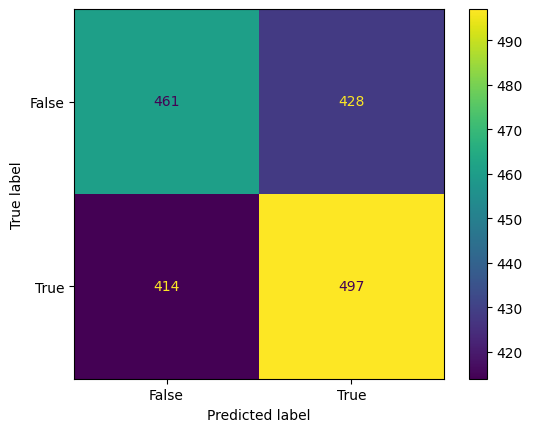

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, Xtesttfidf, y_test)  
plt.show()

In [33]:
Yscore = clf.predict_proba(Xtraintfidf)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def class_roc_auc_score(Ytest, predict, average="macro"):
    lb = LabelBinarizer()
    lb.fit(Ytest)
    Ytest = lb.transform(Ytest)
    predict = lb.transform(predict)
    auc_values = roc_auc_score(Ytest, predict, average=average)
    return auc_values
class_roc_auc_score(y_test, predict)

0.5320572579360621

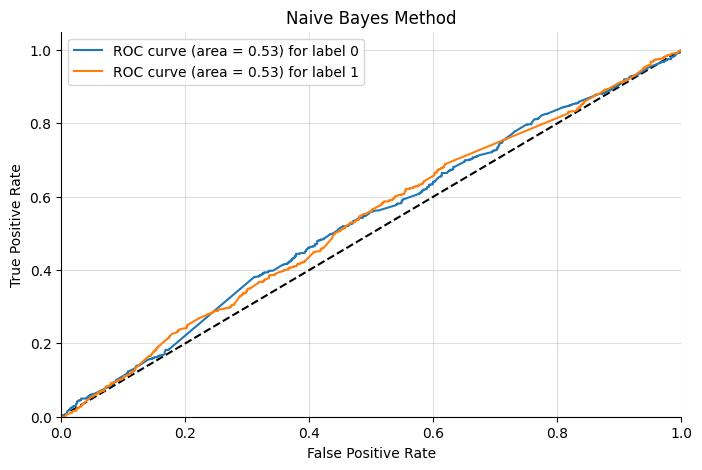

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Naive Bayes Method')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(clf, Xtesttfidf, y_test, n_classes=2, figsize=(8, 5))


#### In conclusion, we find that the accuracy is only 53.22%, which is not a good result, we will increase our sample size so the accuracy will make some changes. And when it comes to f1-score, we can find that they are also bad with 53%. As we can see in the graph above, the ROC-AUC score is 0.5321 and from the confusion matrix plot, we can find that the result is totally different from that of R . It follows its decession rule and it works. In general, the result is not good but if we increase the size of bag of words, the results may make improvement.  And it shows that whether a tweet is retweeted, it depends on its textual content a lot. Then we are dealing with favorited and tweets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df["Clean_Text"], df["favorited"], test_size=0.3, random_state=0)

#### In this method, the assumption of Naive Bayes assumption is that each feature makes an independent and equal contribution to the outcome. And when it comes to texts, we have a concept, which is bag of words as we treat each token independent, conditioned on class label. So we must count vectorizer our texts to get the matrix for maximizing the likelihood.
#### The first step is count vectorizer

In [36]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer()
Xtraincount = countvect.fit_transform(X_train)
Xtraincount.shape

(4200, 6712)

#### The second step is to get Term Frequency times Inverse Document Frequency as it is a quick method to get the input word matrix.

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(use_idf=False).fit(Xtraincount)
Xtraintf = tf.transform(Xtraincount)
Xtraintf.shape

(4200, 6712)

In [40]:
tfidf = TfidfTransformer()
Xtraintfidf = tfidf.fit_transform(Xtraincount)
Xtraintfidf.shape

(4200, 6712)

#### It is the time to train a classifier

In [41]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(Xtraintfidf, y_train)

In [42]:
# predict
Xtestcount = countvect.transform(X_test)
Xtesttfidf = tfidf.transform(Xtestcount)
predict = clf.predict(Xtesttfidf)

#### Evaluating the performance of a classification model, we need to evaluate our model using several different metrics.

#### One common issue is class imbalance, which is when the label distribution in the data varies far from uniform. In this case a high accuracy can be misleading because low frequency labels don't contribute equally to the score. More generally, one of the biggest drawbacks of using MLE in NLP, that is, models tend to be much less sensitive to low probability labels than to higher probabilty labels. 

#### Another reason to use multiple evaluation methods is that it can help us better understand our data. Evaluating performance on individual classes often reveals problems with the data that would otherwise go unnoticed. 

#### In this part we will use some metrics and visualization tools:
##### Accuracy
##### F1 score
##### AUC ROC score
##### The confusion matrix

In [43]:
# Accuracy
from sklearn import metrics
metrics.accuracy_score(y_test,predict)

0.9316666666666666

In [49]:
print("These below are results summaries")
print("----------------------")
print("Accuracy      0.9317")
print("ROC-AUC score 0.5")
print("precision     0.47")
print("recall        0.50")
print("f1-score      0.48")
print("support       1800")
print("----------------------")

These below are results summaries
----------------------
Accuracy      0.9317
ROC-AUC score 0.5
precision     0.47
recall        0.50
f1-score      0.48
support       1800
----------------------


In [44]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96      1677
        True       0.00      0.00      0.00       123

    accuracy                           0.93      1800
   macro avg       0.47      0.50      0.48      1800
weighted avg       0.87      0.93      0.90      1800



/Users/xiaocheng/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaocheng/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaocheng/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [45]:
print("-----------------------------")
print("This is the confusion matrix")
print("-----------------------------")
print(str(metrics.confusion_matrix(y_test, predict)))

-----------------------------
This is the confusion matrix
-----------------------------
[[1677    0]
 [ 123    0]]


/Users/xiaocheng/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


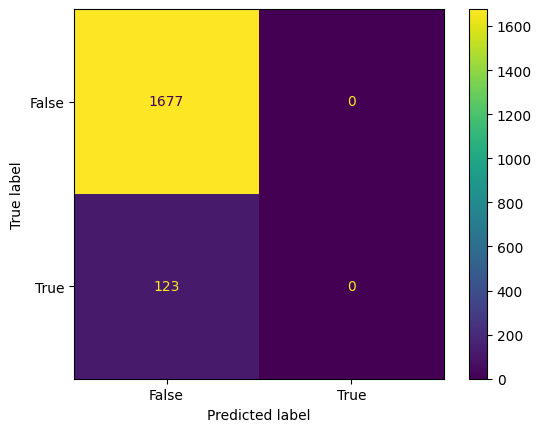

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, Xtesttfidf, y_test)  
plt.show()

In [47]:
Yscore = clf.predict_proba(Xtraintfidf)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def class_roc_auc_score(Ytest, predict, average="macro"):
    lb = LabelBinarizer()
    lb.fit(Ytest)
    Ytest = lb.transform(Ytest)
    predict = lb.transform(predict)
    auc_values = roc_auc_score(Ytest, predict, average=average)
    return auc_values
class_roc_auc_score(y_test, predict)

0.5

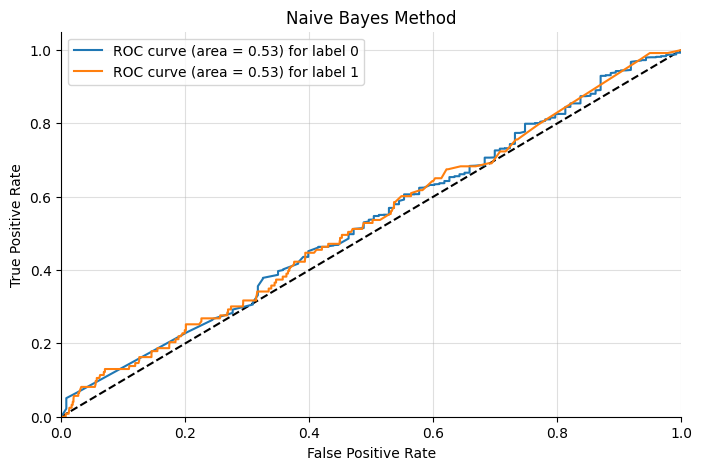

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Naive Bayes Method')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(clf, Xtesttfidf, y_test, n_classes=2, figsize=(8, 5))



#### In conclusion, we find that the accuracy is 93.17%, which is a good result, we will increase our sample size so the accuracy will make some changes. However, when we look at the other three metrics, we would find that this model is not good at all, and this model just predict all tweets as Fasle in favorited, which contains no information. And when it comes to f1-score, we can find that they are also bad with 48%. As we can see in the graph above, the ROC-AUC score is 0.5 and from the confusion matrix plot, we can find that the result is totally different from that of R . It follows its decession rule and it does not work. Besides, the problem here should be the imbalance between True and False in favorited.  In general, the result is not good but if we increase the size of bag of words, the results may make improvement.  And it shows that whether a tweet is favorited, it doesn't depend on its textual content a lot. 